In [1]:
%cd ..
    


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
from notebooks.Utils import calculate_iou, create_random_color
from flaskUtil.ReduceBoxByIntersect import ReduceBoxByIntersect
# from notebooks.Utils import non_max_suppression_iou


In [3]:
from ultralyticsplus import YOLO, render_result

# load model
model_yolov8 = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model_yolov8.overrides['conf'] = 0.25  # NMS confidence threshold
model_yolov8.overrides['iou'] = 0.45  # NMS IoU threshold
model_yolov8.overrides['agnostic_nms'] = False  # NMS class-agnostic
model_yolov8.overrides['max_det'] = 1000  # maximum number of detections per image


In [4]:
from tblDetect.TableDetect import TableDetect
tblDec = TableDetect()

In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests



# you can specify the revision tag if you don't want the timm dependency
processor_detr = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50") #, revision="no_timm")
model_detr = DetrForObjectDetection.from_pretrained("TahaDouaji/detr-doc-table-detection") #, revision="no_timm")

04/23/2024 10:22:56 - INFO - timm.models._builder -   Loading pretrained weights from Hugging Face hub (timm/resnet50.a1_in1k)
04/23/2024 10:22:56 - INFO - timm.models._hub -   [timm/resnet50.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Some weights of the model checkpoint at TahaDouaji/detr-doc-table-detection were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model

In [6]:
import cv2
import numpy as np
font = cv2.FONT_HERSHEY_SIMPLEX 


def tblDec1(image, threshold = 0.1):
    scores, boxes = tblDec.detectTables(image, threshold = threshold)
    return scores.tolist(), boxes.tolist()

def tblDec2(image, threshold = 0.9):
    boxes = []
    labels = []
    scores = []
    results = model_yolov8.predict(image)
    
    for res in results:
        boxes.extend(res.boxes.xyxy.tolist())
        labels.extend(res.boxes.cls.tolist())
        scores.extend(res.boxes.conf.tolist())
    return scores, boxes, labels

def tblDec3(image, threshold = 0.1):
    inputs = processor_detr(images=image, return_tensors="pt")
    outputs = model_detr(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor_detr.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    return results["scores"], np.intp(results["boxes"].tolist()).tolist()


In [7]:
import os
folder = "/Users/eliaweiss/Documents/doc2txt/lineCv/1"
# folder = "/Users/eliaweiss/Documents/doc2txt/sihach/Invoices/3/img3"
file_list = os.listdir(folder)
file_list = [file for file in file_list if 
             ".jpg" in file 
             or ".png" in file 
             or ".jpeg" in file]
file_list = sorted(file_list, key=lambda x: int(
    os.path.splitext(os.path.basename(x))[0]))

In [8]:
fileIter = iter(file_list)
cc = 0

In [9]:



while True:
    file_path = next(fileIter)
    if cc < 0:
        cc+=1    
        continue
    cc+=1    
    
    print(cc)
    
    file_path = os.path.join(folder, file_path)
    print(file_path)

    image = Image.open(file_path)
    scores, boxes = tblDec1(image)
    scores_t, boxes_t,_ = tblDec2(image)
    scores.extend(scores_t)
    boxes.extend(boxes_t)
    scores_t, boxes_t = tblDec3(image)
    scores.extend(scores_t)
    boxes.extend(boxes_t)    
    indices = ReduceBoxByIntersect.reduceBoxByIntersect_indices(boxes)
    

    # Extract the final boxes after NMS
    boxes = [boxes[i] for i in indices]                             
    scores = [scores[i] for i in indices]
 
    tmpImg1 = np.array(image)    
    tmpImg1 = cv2.cvtColor(tmpImg1, cv2.COLOR_BGR2RGB)
    drawWidth = int(2 * tmpImg1.shape[0]*0.001)
    
    for score, box in zip(scores, boxes):
        box = [int(i) for i in box]
        score = f"{int(score*100)}"
        print("prob: ",score)
        l,b,r,t = box
        color = create_random_color()
        cv2.rectangle(tmpImg1,(l,t),(r,b),color,drawWidth)
   
        # Using cv2.putText() method 
        fontScale = drawWidth/2
        tmpImg1 = cv2.putText(tmpImg1, score, (l,t), font,  
                        fontScale, color, drawWidth) 
    cv2.imshow("nms",tmpImg1)    
    cv2.waitKey()
    

1
/Users/eliaweiss/Documents/doc2txt/lineCv/1/0.jpg

0: 640x480 (no detections), 642.6ms
Speed: 2.7ms preprocess, 642.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


prob:  10
prob:  21
prob:  11
prob:  24
2
/Users/eliaweiss/Documents/doc2txt/lineCv/1/1.jpg

0: 640x480 2 borderlesss, 509.9ms
Speed: 1.7ms preprocess, 509.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
prob:  98
prob:  77
prob:  56
prob:  16
prob:  83
3
/Users/eliaweiss/Documents/doc2txt/lineCv/1/2.jpg

0: 640x480 1 bordered, 512.0ms
Speed: 3.5ms preprocess, 512.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)
prob:  14
prob:  94
4
/Users/eliaweiss/Documents/doc2txt/lineCv/1/4.jpg

0: 640x480 (no detections), 501.9ms
Speed: 1.4ms preprocess, 501.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)
prob:  48
prob:  21
prob:  13
prob:  55
5
/Users/eliaweiss/Documents/doc2txt/lineCv/1/5.jpg

0: 640x416 2 bordereds, 1 borderless, 515.8ms
Speed: 2.1ms preprocess, 515.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)
prob:  99
prob:  18
6
/Users/eliaweiss/Documents/doc2txt/lineCv/1/6.jpg

0: 640x512 (no detections)

In [ ]:
file_path = next(fileIter)

print(cc)

file_path = os.path.join(folder, file_path)
print(file_path)

0
/Users/eliaweiss/Documents/doc2txt/lineCv/1/0.jpg


In [ ]:
image = Image.open(file_path)
scores, boxes = tblDec1(image)
scores_t, boxes_t,_ = tblDec2(image)
scores.extend(scores_t)
boxes.extend(boxes_t)
scores_t, boxes_t = tblDec3(image)
scores.extend(scores_t)
boxes.extend(boxes_t)    


0: 640x480 (no detections), 634.2ms
Speed: 3.5ms preprocess, 634.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


prob:  10
prob:  33
prob:  11
prob:  32
prob:  24
prob:  51
prob:  95
prob:  10
prob:  21
prob:  66


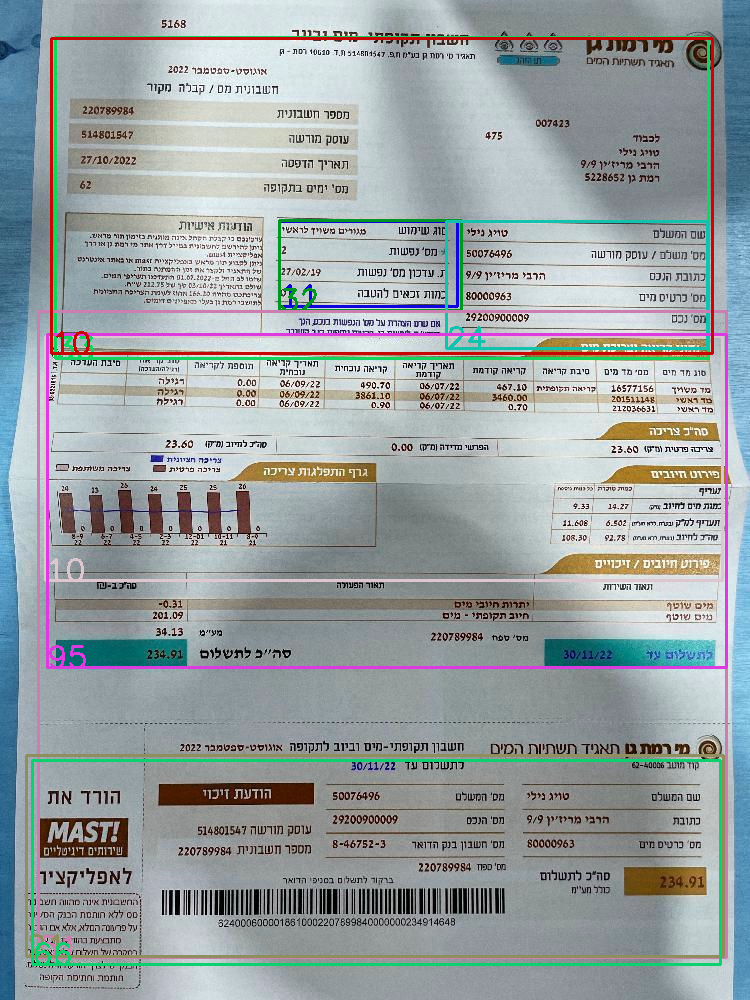

In [ ]:
tmpImg1 = np.array(image)    
tmpImg1 = cv2.cvtColor(tmpImg1, cv2.COLOR_BGR2RGB)
drawWidth = int(2 * tmpImg1.shape[0]*0.001)
for score, box in zip(scores, boxes):
    box = [int(i) for i in box]
    score = f"{int(score*100)}"
    print("prob: ",score)
    l,b,r,t = box
    color = create_random_color()
    cv2.rectangle(tmpImg1,(l,t),(r,b),color,drawWidth)

    # Using cv2.putText() method 
    fontScale = drawWidth/2
    tmpImg1 = cv2.putText(tmpImg1, score, (l,t), font,  
                    fontScale, color, drawWidth) 
Image.fromarray(tmpImg1)

In [ ]:
def showImage_boxes(image, boxes):
    tmpImg1 = np.array(image)    
    tmpImg1 = cv2.cvtColor(tmpImg1, cv2.COLOR_BGR2RGB)
    drawWidth = int(2 * tmpImg1.shape[0]*0.001)
    for box in boxes:
        box = [int(i) for i in box]
        l,b,r,t = box
        color = create_random_color()
        cv2.rectangle(tmpImg1,(l,t),(r,b),color,drawWidth)
    # cv2.imshow("tmpImg1",tmpImg1)
    Image.fromarray(tmpImg1).show()


In [ ]:
selected_box = ReduceBoxByIntersect.reduceBoxByIntersect(boxes)
showImage_boxes(image, selected_box)
